In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from pathlib import Path

import sys
sys.path.append("ComputeCanada/frequency_tagging")
from dfm import (
    f1_f2_data, 
    plot_power_spectrum,
    set_base_dir,
    analyze_rois,
    extract_im_products,
    get_roi_colour_codes,
    get_frequency_text_codes,
    change_font,
)
change_font()

/opt/app/notebooks/font_library/aptos-semibold.ttf
/opt/app/notebooks/font_library/aptos-extrabold-italic.ttf
/opt/app/notebooks/font_library/aptos-extrabold-italic 2.ttf
/opt/app/notebooks/font_library/aptos-black-italic.ttf
/opt/app/notebooks/font_library/aptos-italic.ttf
/opt/app/notebooks/font_library/aptos-light-italic.ttf
/opt/app/notebooks/font_library/aptos-light.ttf
/opt/app/notebooks/font_library/aptos-extrabold.ttf
/opt/app/notebooks/font_library/aptos-black.ttf
/opt/app/notebooks/font_library/aptos.ttf
/opt/app/notebooks/font_library/aptos-bold.ttf


Cohort info

In [2]:
VARY_3T = (
    "1_frequency_tagging",
    "3T",
    {
        "020": [
            ("entrainA", [.125, .2]),
            ("entrainB", [.125, .175]),
            ("entrainC", [.125, .15]),
        ],
        "021": [
            ("entrainD", [.125, .2]),
            ("entrainE", [.15, .2]),
            ("entrainF", [.175, .2]),
        ],
    }
)
VARY_7T = (
    "1_frequency_tagging",
    "7T",
    {
        "020": [
            ("entrainA", [.125, .2]),
            ("entrainB", [.125, .175]),
            ("entrainC", [.125, .15]),
        ],
        "021": [
            ("entrainD", [.125, .2]),
            ("entrainE", [.15, .2]),
            ("entrainF", [.175, .2]),
        ],
    }
)

task_to_test_frequencies_map = {
    "entrainA": [.125, .2],
    "entrainD": [.125, .2],
    "entrainB": [.125, .175],
    "entrainC": [.125, .15],
    "entrainE": [.15, .2],
    "entrainF": [.175, .2],
}

def read_data(d):
    return d[0], d[1], d[2]

def save_bootstrapped_statistics(pkl_path, data_dict):
    import pickle
    with open(pkl_path, 'wb') as f:
        pickle.dump(data_dict, f)

def load_bootstrapped_statistics(pkl_path):
    import pickle
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

Save all statistics as pickle files

In [3]:
def get_control_task_ids_for_vary_experiments(sub_id, task_id):
    if sub_id == "020":
        if task_id == "entrainA":
            return ["entrainB", "entrainC"]
        elif task_id == "entrainB":
            return ["entrainA", "entrainC"]
        elif task_id == "entrainC":
            return ["entrainA", "entrainB"]
    elif sub_id == "021":
        if task_id == "entrainD":
            return ["entrainE", "entrainF"]
        elif task_id == "entrainE":
            return ["entrainD", "entrainF"]
        elif task_id == "entrainF":
            return ["entrainD", "entrainE"]
    else:
        raise ValueError(f"Not implemented: {sub_id} {task_id}")

def store_data_in_dict(
    experiment_id,
    sub_id,
    roi_task_id,
    roi_pval,
    roi_fractional_overlap,
    roi_f_type,
    rephase,
    rephase_with,
    im_test_frequencies_map,
    data_dict,
    n_bootstraps,
    task_id,
    label,
    loaded_data_dict = None
):
    if loaded_data_dict is None:
        group_data_dict = defaultdict(list)
    else:
        group_data_dict = loaded_data_dict
    group_data_dict["experiment_id"].append(experiment_id)
    group_data_dict["sub_id"].append(sub_id)
    group_data_dict["roi_task_id"].append(roi_task_id)
    group_data_dict["roi_pval"].append(roi_pval)
    group_data_dict["roi_fractional_overlap"].append(roi_fractional_overlap)
    group_data_dict["roi_f_type"].append(roi_f_type)
    group_data_dict["rephase"].append(rephase)
    group_data_dict["rephase_with"].append(rephase_with)
    group_data_dict["task_id"].append(task_id)
    group_data_dict["label"].append(label)

    for metric_f_type, metric_f_value in im_test_frequencies_map.items():
        group_data_dict[metric_f_type].append(metric_f_value)
        group_data_dict[f"power_{metric_f_type}"].append(data_dict['observed_statistics'][metric_f_value])
        group_data_dict[f"pval_{metric_f_type}"].append(-np.log10(data_dict['p_values'][metric_f_value]))
        group_data_dict[f"bootstrap_power_{metric_f_type}"].append(np.median([i[1] for i in data_dict['bootstrapped_statistics'][f'test-{metric_f_value}']]))
        group_data_dict[f"bootstrap_pval_{metric_f_type}"].append(np.sum([-np.log10(i[0]) > -np.log10(.05) for i in data_dict['bootstrapped_statistics'][f'test-{metric_f_value}']]) / n_bootstraps)

    group_data_dict["power_spectrum"].append(data_dict["observed_power_spectrum"])

    return group_data_dict
    

In [4]:
datadir = Path("/scratch/fastfmri")
n_permutations = 1000
n_bootstraps = 200
TR = .3
fos = [.8]
pvals = ["uncp", "fdrp"]
nperseg = 570

# directories
fig_dir = Path(set_base_dir(f"./ComputeCanada/frequency_tagging/figures/dual_frequency_roi_psd"))
pickle_dir = Path(set_base_dir(f"/scratch/fastfmri/pickles"))

# data stores
frequency_grid = None # track, ensuring frequency_grid is consistent
#experiment_info = []
group_data_dict = None
# Loop over roi params: fos and pvals
for fo, pval in itertools.product(fos, pvals):

    # Loop over datasets
    dataset_ids = [VARY_3T, VARY_7T]
    dataset_labels = ["VARY_3T", "VARY_7T"]
    for dataset_ix, (dataset_label, dataset_id) in enumerate(zip(dataset_labels, dataset_ids)):
        experiment_id, mri_id, sub_to_task_mapping = read_data(dataset_id)

        # Loop over subjects
        for sub_ix, (sub_id, sub_task_info) in enumerate(sub_to_task_mapping.items()):
            for task_ix, (roi_task_id, _) in enumerate(sub_task_info):


                task_id = roi_task_id
                control_task_ids = get_control_task_ids_for_vary_experiments(sub_id, task_id)

                test_frequencies = task_to_test_frequencies_map[task_id] # Load first order frequencies
                assert len(test_frequencies) == 2 and test_frequencies[0] < test_frequencies[1]
                control_test_frequencies = [task_to_test_frequencies_map[task_id] for task_id in control_task_ids]
                assert len(control_test_frequencies) == 2
                
                print(f"This `pkl_handler` uses ROI: {roi_task_id}, and {task_id}")
                pkl_handler = f1_f2_data(
                    datadir, 
                    n_bootstraps, 
                    sub_id, 
                    roi_task_id, 
                    test_frequencies[0], test_frequencies[1], 
                    task_id, 
                    experiment_id=experiment_id, 
                    mri_id=mri_id, 
                    fo=fo, 
                    pval=pval
                )

                # Update frequencies to get secondary, and tertiary IM frequencies
                im_test_frequencies_map = {
                    (task_id, "TEST"): extract_im_products(test_frequencies[0], test_frequencies[1]),
                }
                for _task_id, _test_frequencies in zip(control_task_ids, control_test_frequencies):
                    im_test_frequencies_map[_task_id, "CONTROL"] = extract_im_products(_test_frequencies[0], _test_frequencies[1])

                for k, v in im_test_frequencies_map.items():
                    task_id, task_label = k
                    im_test_frequencies = [i for i in v.values()]

                    info = (
                        f"Processing {dataset_label}, sub-{sub_id}, roi-task-id-{roi_task_id}, task-{task_id}, pval-{pval}, fo-{fo}\n"
                        f"   - Primary frequencies: {test_frequencies}\n"
                        f"   - [{task_id}/{task_label}] Test frequencies: {im_test_frequencies}"
                    )
                    print(info)

                    # Loop over rephase (enabling rephasing of timeseries with phase delay), frequency of ROIs (f1, f2, f1&f2)
                    for rephase, f_type in itertools.product([True,False], ["f1", "f2", "f1f2"]):
                        if rephase and f_type == "f1f2":
                            n_intersected_rois = (pkl_handler.f_data['f1']['roi_coords'] * pkl_handler.f_data['f2']['roi_coords']).sum()
                            if n_intersected_rois.sum() == 0:
                                print(f"Skipping since 0 voxels were found at the intersection.")
                                continue
                            for rephase_with in ["f1", "f2"]:
                                if task_label == "TEST":
                                    pkl_path = pickle_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}-{rephase_with}_pval-{pval}_fo-{fo}.pkl"
                                else:
                                    pkl_path = pickle_dir / f"control-label-{task_id}-{task_label}_experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}-{rephase_with}_pval-{pval}_fo-{fo}.pkl"
                                if pkl_path.exists():
                                    data_dict = load_bootstrapped_statistics(pkl_path)
                                else:
                                    frequency_grid, observed_statistics, observed_power_spectrum, null_power_spectrums, p_values, bootstrapped_statistics = analyze_rois(
                                        pkl_handler, 
                                        f_type, 
                                        im_test_frequencies, 
                                        n_bootstraps, 
                                        TR, 
                                        n_permutations=n_permutations, 
                                        nperseg=nperseg, 
                                        rephase=rephase, 
                                        rephase_with=rephase_with,
                                        frequency_grid=frequency_grid,
                                    )
                                    # Save pkl_path
                                    data_dict = {
                                        "frequency_grid": frequency_grid, 
                                        "observed_power_spectrum": observed_power_spectrum, 
                                        "null_power_spectrums": null_power_spectrums, 
                                        "observed_statistics": observed_statistics, 
                                        "p_values": p_values, 
                                        "bootstrapped_statistics": bootstrapped_statistics,
                                    }
                                    save_bootstrapped_statistics(pkl_path, data_dict)
                                group_data_dict = store_data_in_dict(
                                    dataset_label, sub_id,
                                    roi_task_id, pval, fo, f_type,
                                    rephase, rephase_with,
                                    im_test_frequencies_map[k], data_dict,
                                    n_bootstraps, task_id, task_label,
                                    loaded_data_dict=group_data_dict
                                )
                        else:
                            if task_label == "TEST":
                                pkl_path = pickle_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}_pval-{pval}_fo-{fo}.pkl"
                            else:
                                pkl_path = pickle_dir / f"control-label-{task_id}-{task_label}_experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}-{f_type}_task-{task_id}_rephase-{rephase}_pval-{pval}_fo-{fo}.pkl"
                            if pkl_path.exists():
                                data_dict = load_bootstrapped_statistics(pkl_path)
                            else:
                                frequency_grid, observed_statistics, observed_power_spectrum, null_power_spectrums, p_values, bootstrapped_statistics = analyze_rois(
                                    pkl_handler, 
                                    f_type, 
                                    im_test_frequencies, 
                                    n_bootstraps, 
                                    TR, 
                                    n_permutations=n_permutations, 
                                    nperseg=nperseg, 
                                    rephase=rephase,
                                    rephase_with=None,
                                    frequency_grid=frequency_grid,
                                )
                                # Save pkl_path
                                data_dict = {
                                    "frequency_grid": frequency_grid, 
                                    "observed_power_spectrum": observed_power_spectrum, 
                                    "null_power_spectrums": null_power_spectrums, 
                                    "observed_statistics": observed_statistics, 
                                    "p_values": p_values, 
                                    "bootstrapped_statistics": bootstrapped_statistics,
                                }
                                save_bootstrapped_statistics(pkl_path, data_dict)
                            group_data_dict = store_data_in_dict(
                                dataset_label, sub_id,
                                roi_task_id, pval, fo, f_type,
                                rephase, None,
                                im_test_frequencies_map[k], data_dict,
                                n_bootstraps, task_id, task_label,
                                loaded_data_dict=group_data_dict
                            )

df = pd.DataFrame(group_data_dict)

This `pkl_handler` uses ROI: entrainA, and entrainA
Processing VARY_3T, sub-020, roi-task-id-entrainA, task-entrainA, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - [entrainA/TEST] Test frequencies: [0.125, 0.2, 0.075, 0.325, 0.25, 0.4, 0.05, 0.275]
Processing VARY_3T, sub-020, roi-task-id-entrainA, task-entrainB, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - [entrainB/CONTROL] Test frequencies: [0.125, 0.175, 0.05, 0.3, 0.25, 0.35, 0.075, 0.225]
Processing VARY_3T, sub-020, roi-task-id-entrainA, task-entrainC, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.2]
   - [entrainC/CONTROL] Test frequencies: [0.125, 0.15, 0.025, 0.275, 0.25, 0.3, 0.1, 0.175]
This `pkl_handler` uses ROI: entrainB, and entrainB
Processing VARY_3T, sub-020, roi-task-id-entrainB, task-entrainB, pval-uncp, fo-0.8
   - Primary frequencies: [0.125, 0.175]
   - [entrainB/TEST] Test frequencies: [0.125, 0.175, 0.05, 0.3, 0.25, 0.35, 0.075, 0.225]
Processing VARY_3T, sub-020, roi-t

Note: `task_id` column in `df` only indicates the IM frequencies to be tested, and the task used to generate the PSD is indicated by `roi_task_id`

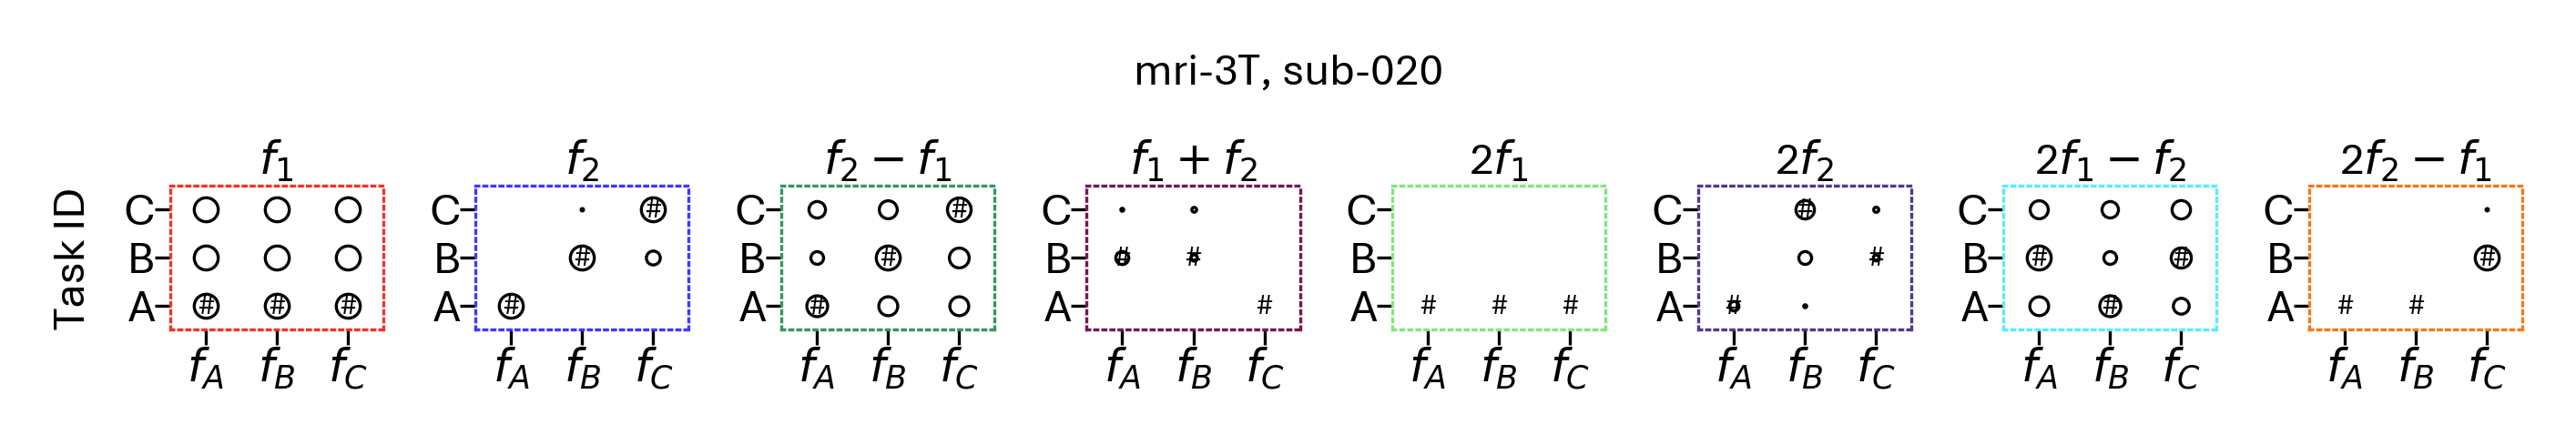

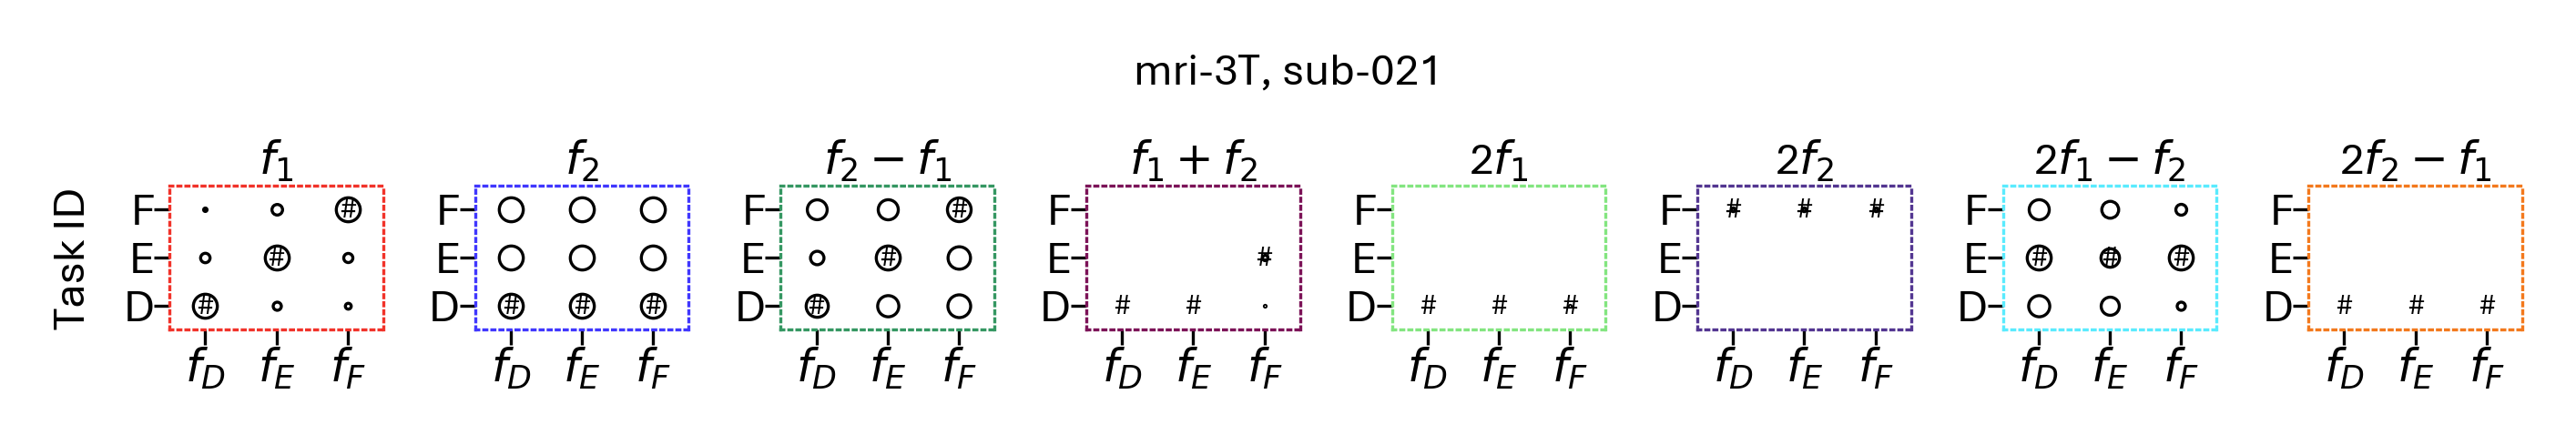

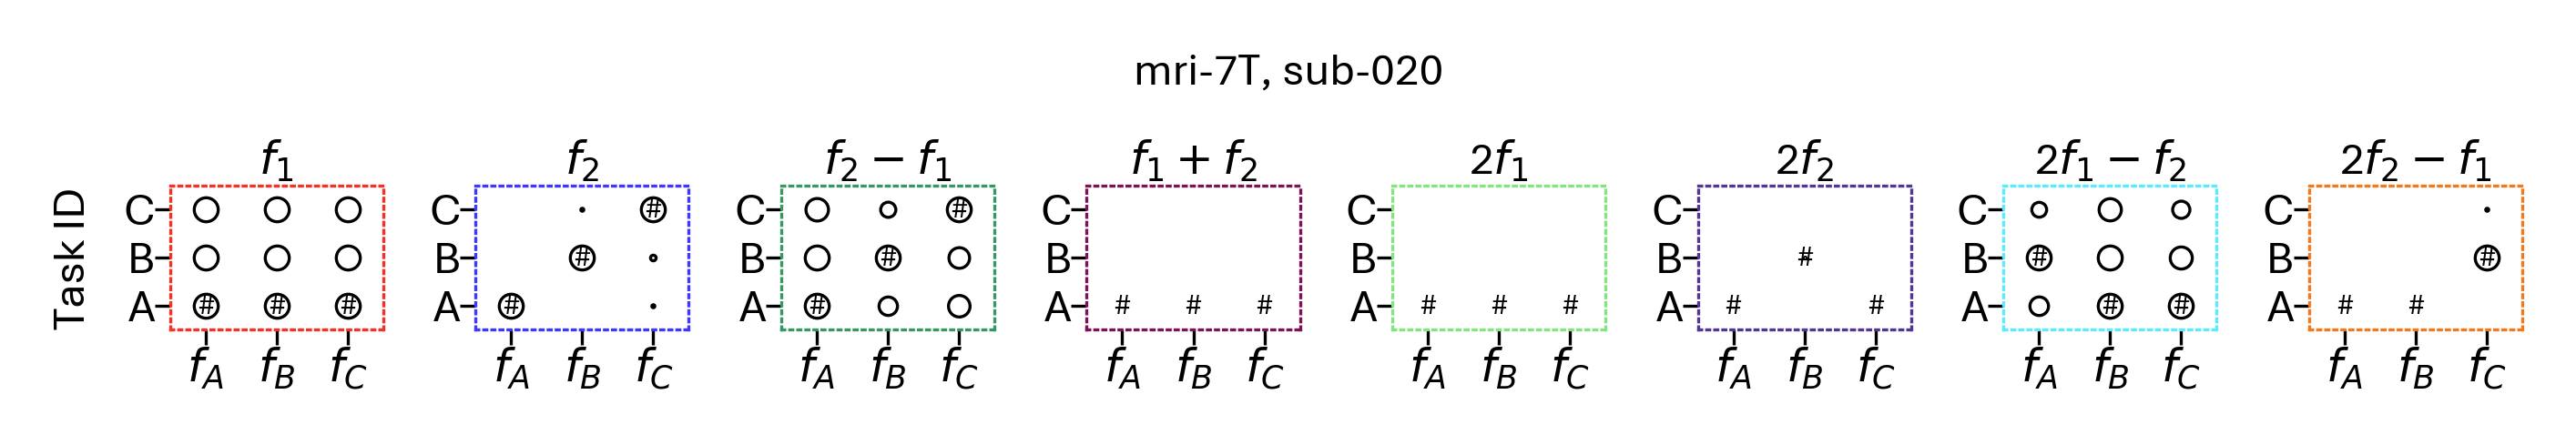

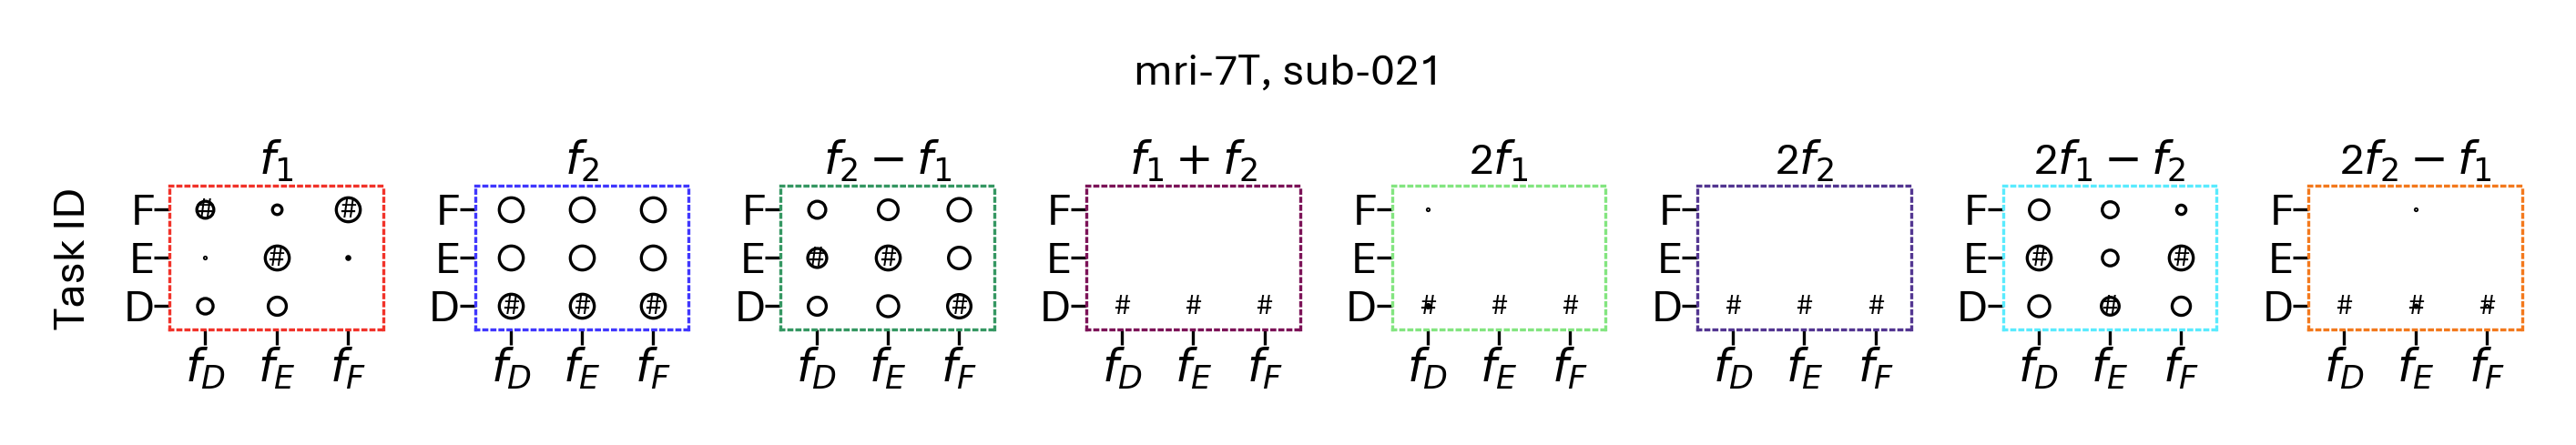

In [22]:
import itertools
im_scale = .7
FONTSIZE = 6
LINEWIDTH = .4
frequency_text_codes = get_frequency_text_codes()
roi_c_dict = get_roi_colour_codes()

roi_f_type = "f1f2"
roi_pval = "uncp"
roi_fractional_overlap = 0.8
rephase = False
rephase_with = None

experiment_ids = ["VARY_3T","VARY_7T"]
sub_ids = ["020","021"]
im_f_types = [i for i in im_test_frequencies_map[k].keys()]

for experiment_id, sub_id in itertools.product(experiment_ids, sub_ids):
    if sub_id == "020":
        roi_task_ids = ["entrainA","entrainB","entrainC"]
    elif sub_id == "021":
        roi_task_ids = ["entrainD","entrainE","entrainF"]
    else:
        raise ValueError()

    fig, ax_dict = plt.subplot_mosaic([im_f_types],figsize=(len(im_f_types)*im_scale-1,im_scale*1),dpi=600, layout="constrained")

    for im_f_type in im_f_types:
        ax = ax_dict[im_f_type]

        x_labels = []
        plotted_data = np.zeros((3,3))
        for roi_ix, roi_task_id in enumerate(roi_task_ids):
            subset_df = df[
                (df.experiment_id==experiment_id) & \
                (df.sub_id==sub_id) & \
                (df.roi_pval==roi_pval) & \
                (df.roi_fractional_overlap==roi_fractional_overlap) & \
                (df.roi_f_type==roi_f_type) & \
                (df.rephase==rephase) & \
                (~df.rephase_with.notnull()) & \
                (df.roi_task_id==roi_task_id)
            ][["task_id","roi_task_id",im_f_type,"label",f"bootstrap_pval_{im_f_type}"]]
            values = []
            for i,roi_task_id in enumerate(roi_task_ids):
                values.append(subset_df[(subset_df.task_id==roi_task_id)][f"bootstrap_pval_{im_f_type}"].values[0])
                if roi_ix == 0:
                    x_labels.append(subset_df[(subset_df.task_id==roi_task_id)][im_f_type].values[0])
            plotted_data[roi_ix,:] = values

        interval = .5
        for i,j in itertools.product(range(3),range(3)):
            x_pos = j+interval
            y_pos = i+interval
            ax.scatter(x_pos,y_pos,s=10*plotted_data[i,j],c='white',edgecolor='k',linewidths=0.4,zorder=1)
        argmax = np.argmax(plotted_data, axis=0)
        for col_pos, row_pos in enumerate(argmax):
            ax.text(col_pos+interval,row_pos+interval,"#",c='k',fontsize=FONTSIZE-2,ha="center",va="center",zorder=2)
        
        ax.set_xlim(0,3)
        ax.set_ylim(0,3)
        ax.set_xticks([.5,1.5,2.5])
        ax.set_yticks([.5,1.5,2.5])
        labels = [i.split("entrain")[-1] for i in roi_task_ids]
        ax.set_xticklabels([f"$f_{i}$" for i in labels], fontsize=FONTSIZE)
        ax.set_yticklabels(labels, fontsize=FONTSIZE)
        ax.set_title(frequency_text_codes[im_f_type], fontsize=FONTSIZE,pad=1.5)
        ax.tick_params(axis="both", length=2.,width=LINEWIDTH,pad=0,labelsize=FONTSIZE)
        for _spine in ["top","right","bottom","left"]:
            ax.spines[_spine].set_linewidth(LINEWIDTH)
            ax.spines[_spine].set_linestyle("dotted")
            ax.spines[_spine].set_edgecolor(roi_c_dict[im_f_type])
        

    ax_dict['f1'].set_ylabel("Task ID",fontsize=FONTSIZE)
    mri_id = experiment_id.split("_")[-1]
    fig.suptitle(f"mri-{mri_id}, sub-{sub_id}", fontsize=FONTSIZE,)